In [1]:
# --- [Imports] ---
import os
import numpy as np
import cv2
import shutil
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# --- [Constants] ---
IMG_SIZE = 128
CONFIDENCE_THRESHOLD = 0.70
class_labels = {0: "Benign", 1: "Malignant", 2: "Normal"}

# --- [Dataset Paths] ---
dataset_path = r"C:\Users\Sowjanya\Desktop\cancer_project\The IQ-OTHNCCD lung cancer dataset"
benign_dir = os.path.join(dataset_path, "Bengin cases")
malignant_dir = os.path.join(dataset_path, "Malignant cases")
normal_dir = os.path.join(dataset_path, "Normal cases")

# --- [Load Images] ---
def load_images_from_directory(directory, label):
    images, labels = [], []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        images.append(img)
        labels.append(label)
    return images, labels

benign_images, benign_labels = load_images_from_directory(benign_dir, 0)
malignant_images, malignant_labels = load_images_from_directory(malignant_dir, 1)
normal_images, normal_labels = load_images_from_directory(normal_dir, 2)

images = np.array(benign_images + malignant_images + normal_images)
labels = np.array(benign_labels + malignant_labels + normal_labels)

# Print dataset details
print(f"Total Images Loaded: {len(images)}")
print(f"Benign Cases: {len(benign_images)} images")
print(f"Malignant Cases: {len(malignant_images)} images")
print(f"Normal Cases: {len(normal_images)} images")

# --- [Train-Test Split] ---
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)
y_train_encoded = to_categorical(y_train, 3)
y_test_encoded = to_categorical(y_test, 3)


Total Images Loaded: 1097
Benign Cases: 120 images
Malignant Cases: 561 images
Normal Cases: 416 images


In [3]:
# --- [Model Builder Function for Keras Tuner] ---
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    # Hyperparameters to tune
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- [Clean Tuner Directory] ---
if os.path.exists("bayesian_search"):
    shutil.rmtree("bayesian_search")

# --- [Tuner Setup] ---
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='bayesian_search',
    project_name='lung_cancer_tuning'
)

# --- [Define Search Space for batch_size and epochs] ---
hp = kt.HyperParameters()
batch_size_list = [16, 32, 64, 128]
epoch_list = [5, 10, 15, 20]
best_result = None
best_val_acc = 0

# --- [Manual Grid Search for batch size and epochs] ---
for batch_size in batch_size_list:
    for epochs in epoch_list:
        print(f"\nTrying: Batch Size = {batch_size}, Epochs = {epochs}")
        tuner.search(
            X_train,
            y_train_encoded,
            validation_split=0.2,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0
        )
        best_hp = tuner.get_best_hyperparameters(1)[0]
        model = tuner.hypermodel.build(best_hp)
        history = model.fit(
            X_train, y_train_encoded,
            validation_split=0.2,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )
        val_acc = history.history['val_accuracy'][-1]
        print(f"Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_result = {
                'learning_rate': best_hp.get('learning_rate'),
                'batch_size': batch_size,
                'epochs': epochs
            }

# --- [Best Hyperparameters Output] ---
print("\nBest Hyperparameters Found:")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Epochs: {best_result['epochs']}")

C:\Users\Sowjanya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Trying: Batch Size = 16, Epochs = 5



C:\Users\Sowjanya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Sowjanya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.9545

Trying: Batch Size = 16, Epochs = 10
Validation Accuracy: 0.9773

Trying: Batch Size = 16, Epochs = 15
Validation Accuracy: 0.9602

Trying: Batch Size = 16, Epochs = 20
Validation Accuracy: 0.9773

Trying: Batch Size = 32, Epochs = 5
Validation Accuracy: 0.9205

Trying: Batch Size = 32, Epochs = 10
Validation Accuracy: 0.9773

Trying: Batch Size = 32, Epochs = 15
Validation Accuracy: 0.9716

Trying: Batch Size = 32, Epochs = 20
Validation Accuracy: 0.9830

Trying: Batch Size = 64, Epochs = 5
Validation Accuracy: 0.9659

Trying: Batch Size = 64, Epochs = 10
Validation Accuracy: 0.9489

Trying: Batch Size = 64, Epochs = 15
Validation Accuracy: 0.9773

Trying: Batch Size = 64, Epochs = 20
Validation Accuracy: 0.9830

Trying: Batch Size = 128, Epochs = 5
Validation Accuracy: 0.7330

Trying: Batch Size = 128, Epochs = 10
Validation Accuracy: 0.9489

Trying: Batch Size = 128, Epochs = 15
Validation Accuracy: 0.9602

Trying: Batch Size = 128, Epochs = 20
Validatio

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 0.5001 - loss: 1.8454 - val_accuracy: 0.7364 - val_loss: 0.6219
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - accuracy: 0.8072 - loss: 0.5411 - val_accuracy: 0.9136 - val_loss: 0.2557
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.9050 - loss: 0.2409 - val_accuracy: 0.9682 - val_loss: 0.1245
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.9651 - loss: 0.0911 - val_accuracy: 0.9773 - val_loss: 0.0640
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step - accuracy: 0.9841 - loss: 0.0591 - val_accuracy: 0.9682 - val_loss: 0.0747
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 326ms/step - accuracy: 0.9885 - loss: 0.0427 - val_accuracy: 0.9818 - val_loss: 0.0704
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.9817 - loss: 0.0646 - val_accuracy: 0.9909 - val_loss: 0.0571
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.9859 - loss: 0.0455 - val_accuracy: 

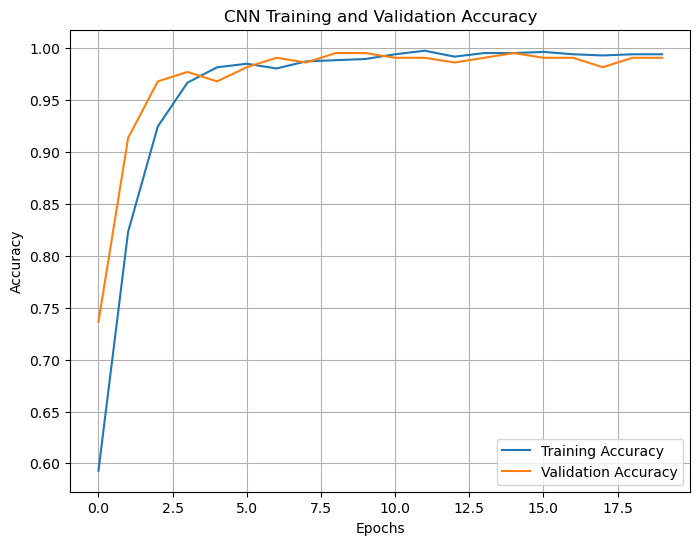

In [5]:
# --- [Train Final Model with Best Hyperparameters] ---
final_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

final_model.compile(
    optimizer=Adam(learning_rate=best_result['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = final_model.fit(
    X_train, y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    batch_size=best_result['batch_size'],
    epochs=best_result['epochs'],
    verbose=1
)

# --- [Evaluate Final Model] ---
test_loss, test_acc = final_model.evaluate(X_test, y_test_encoded)

final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"\nTraining Accuracy: {final_train_accuracy:.4f}")
print(f"Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# --- [Plot Accuracy] ---
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()



Retraining the model with best hyperparameters...
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - accuracy: 0.9966 - loss: 0.0076 - val_accuracy: 0.9864 - val_loss: 0.0568
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.9989 - loss: 0.0054 - val_accuracy: 0.9818 - val_loss: 0.0598
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.9922 - loss: 0.0138 - val_accuracy: 0.9864 - val_loss: 0.0399
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.9953 - loss: 0.0230 - val_accuracy: 0.9955 - val_loss: 0.0315
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.9959 - loss: 0.0117 - val_accuracy: 0.9909 - val_loss: 0.0320
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 325ms/step - accuracy: 0.9944 - loss: 0.0077 - val_accuracy: 0.9955 - val_loss: 0.0291
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - accuracy: 0.9978 - loss: 0.0047 - val_accuracy: 0.9909 - val_loss: 0.0437
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/st

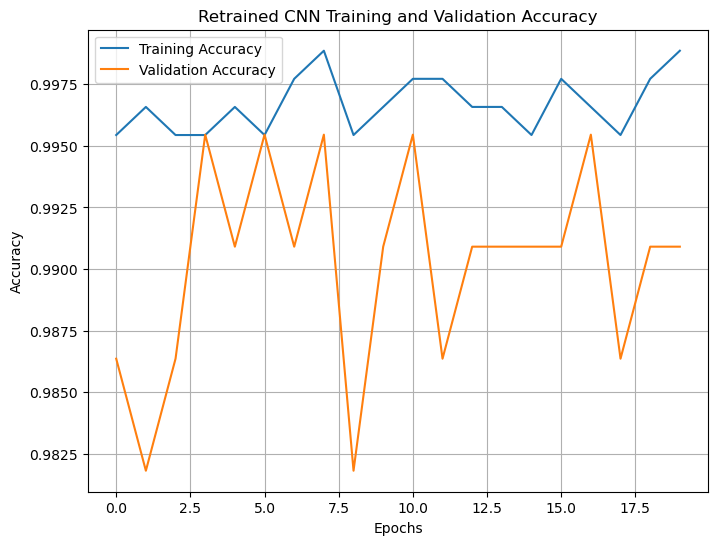

In [7]:
# --- [Retraining the Model with Best Hyperparameters] ---
print("\nRetraining the model with best hyperparameters...")
retrain_history = final_model.fit(
    X_train, y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    batch_size=best_result['batch_size'],
    epochs=best_result['epochs'],
    verbose=1
)

# --- [Retrained Model Accuracy] ---
retrain_train_accuracy = retrain_history.history['accuracy'][-1]
retrain_val_accuracy = retrain_history.history['val_accuracy'][-1]

print(f"\nRetrained Model - Training Accuracy: {retrain_train_accuracy:.4f}")
print(f"Retrained Model - Validation Accuracy: {retrain_val_accuracy:.4f}")

# --- [Plot Retrained Model Accuracy] ---
plt.figure(figsize=(8, 6))
plt.plot(retrain_history.history['accuracy'], label='Training Accuracy')
plt.plot(retrain_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Retrained CNN Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

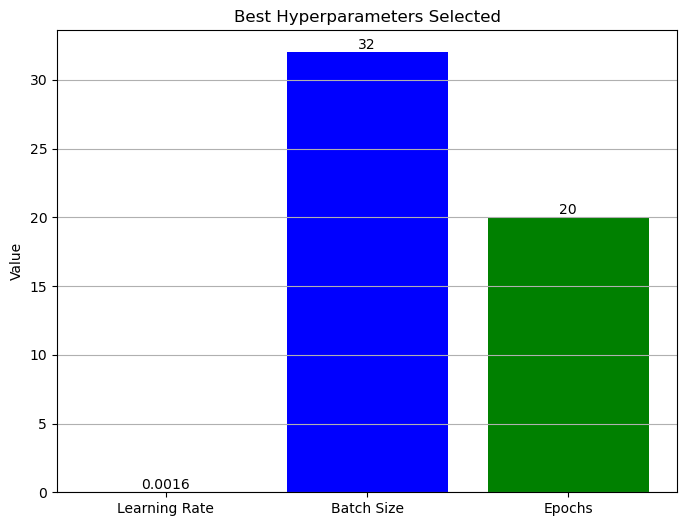

In [9]:
# --- [Plot Best Hyperparameters] ---
plt.figure(figsize=(8, 6))
plt.bar(["Learning Rate", "Batch Size", "Epochs"],
        [best_result['learning_rate'], best_result['batch_size'], best_result['epochs']],
        color=['orange', 'blue', 'green'])
plt.title("Best Hyperparameters Selected")
plt.ylabel("Value")
for i, val in enumerate([best_result['learning_rate'], best_result['batch_size'], best_result['epochs']]):
    plt.text(i, val, f"{val:.4f}" if isinstance(val, float) else f"{val}", ha='center', va='bottom')
plt.grid(True, axis='y')
plt.show()


In [11]:
# --- [Predictions and Report] ---
y_pred_probs = final_model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred_labels,
    target_names=[class_labels[0], class_labels[1], class_labels[2]]
))

print("Accuracy of the Model: {:.1f}%".format(accuracy_score(y_test, y_pred_labels) * 100))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        24
   Malignant       1.00      0.99      1.00       113
      Normal       0.99      0.99      0.99        83

    accuracy                           0.99       220
   macro avg       0.98      0.99      0.99       220
weighted avg       0.99      0.99      0.99       220

Accuracy of the Model: 99.1%


Enter the path of the lung CT scan image:  C:\Users\Sowjanya\Desktop\cancer_project\The IQ-OTHNCCD lung cancer dataset\b.jpg


🔎 SSIM check skipped (test mode).


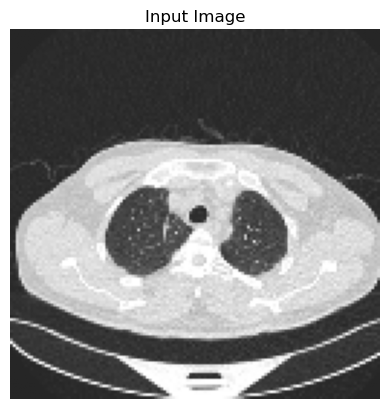

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
🔬 Predicted Class: Benign
📊 Confidence: 0.97


In [17]:
def is_similar_to_dataset(image, sample_images, threshold=0.08, warning_threshold=0.12, sample_size=30, visualize=True):
    def preprocess_for_ssim(img):
        img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        equalized = cv2.equalizeHist(gray)
        return equalized

    image_proc = preprocess_for_ssim(image)
    selected_samples = random.sample(sample_images, min(sample_size, len(sample_images)))
    scores = []

    for sample in selected_samples:
        sample_proc = preprocess_for_ssim(sample)
        score, _ = ssim(image_proc, sample_proc, full=True)
        scores.append(score)

    avg_score = np.mean(scores)
    print(f"[DEBUG] SSIM with dataset avg (after equalization): {avg_score:.4f}")

    # Visualize comparison
    if visualize:
        plt.figure(figsize=(12, 3))
        plt.subplot(1, 6, 1)
        plt.imshow(image_proc, cmap='gray')
        plt.title("Input")
        plt.axis("off")

        for i in range(min(5, len(selected_samples))):
            plt.subplot(1, 6, i + 2)
            plt.imshow(preprocess_for_ssim(selected_samples[i]), cmap='gray')
            plt.title(f"Sample {i + 1}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

    if avg_score < threshold:
        return 'reject'
    elif avg_score < warning_threshold:
        return 'warn'
    else:
        return 'accept'

# === Prediction Function ===
def predict_lung_cancer(image_path, skip_ssim=False):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Invalid image path.")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image_rgb, (IMG_SIZE, IMG_SIZE)) / 255.0

    if not skip_ssim:
        sample_images = [images[i] for i in random.sample(range(len(images)), 30)]
        similarity_status = is_similar_to_dataset(resized, sample_images)

        if similarity_status == 'reject':
            print("❌ Rejected: This image does NOT resemble a valid lung CT scan. Please check the input.")
            return
        elif similarity_status == 'warn':
            print("⚠️ Warning: Image may not closely resemble standard CT scans. Proceeding with caution...")
    else:
        print("🔎 SSIM check skipped (test mode).")

    # Show image
    plt.imshow(resized)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    # Predict
    prediction = model.predict(np.expand_dims(resized, axis=0))[0]
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    print(f"🔬 Predicted Class: {class_labels[predicted_class]}")
    print(f"📊 Confidence: {confidence:.2f}")

    if confidence < CONFIDENCE_THRESHOLD:
        print("⚠️ Warning: Model is not confident about this prediction!")

# === Run Prediction ===
image_path = input("Enter the path of the lung CT scan image: ").strip()
# Use skip_ssim=True only for debugging or dataset testing
predict_lung_cancer(image_path, skip_ssim=True)